# Compound data acquisition from Chembl

In [56]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm
# or from tqdm.notebook import tqdm
# <tqdm> tqdm shows preprocessing time in real time

# <PandasTools> PandasTools enables using RDKit molecules as columns of a Pandas DataFrame

In [57]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [58]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [59]:
# Target Protein --> EGFP kinase: P00533

uniprot_id = "P00533"

In [60]:
#### Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [61]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
5,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Baculoviral IAP repeat-containing protein 2/Ep...,CHEMBL4802031,PROTEIN-PROTEIN INTERACTION


In [62]:
# Select target (target Chembl id)

target = targets.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

In [63]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL203


In [64]:
#### Fetch bioactivity data for the target from ChEMBL
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 10420, <class 'chembl_webresource_client.query_set.QuerySet'>


In [65]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

In [66]:
# This step should not take more than 2 minutes
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (10420, 13)


In [67]:
#### Preprocess and filter bioactivity data
#### Convert standard_value’s datatype from object to float
#### Delete entries with missing values
#### Keep only entries with standard_unit == nM
#### Delete duplicate molecules
#### Reset DataFrame index
#### Rename columns

In [68]:
bioactivities_df["units"].unique()

# When you want to remove duplicate values from a specific column and get only unique values, use unique() and drop_duplicates()
# df["column's name"].unique() --> Return unique values in array type
# df["column's name"].drop_duplicates() --> Return unique values in Series type
# When you want to return to DataFrame, use df.drop_duplicate(subset="column's name")

array(['uM', 'nM', 'pM', 'M', "10'3 uM", "10'1 ug/ml", 'ug ml-1',
       "10'-1microM", "10'1 uM", "10'-1 ug/ml", "10'-2 ug/ml", "10'2 uM",
       "10'-3 ug/ml", "10'-2microM", '/uM', "10'-6g/ml", 'mM', 'umol/L',
       'nmol/L', "10'-10M", "10'-7M", 'nmol', '10^-8M', 'µM'],
      dtype=object)

In [69]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [70]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [71]:
# Convert datatype of “standard_value” from “object” to “float” for Caculation
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [72]:
# Delete entries with missing values
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

# df.dropna() --> Wenn there is "NaN" value in DataFrame, this function delete row or column including "NaN" value
# Parameter in dropna() --> how = "any"/"all"
# "any" --> when there is at least only 1 "NaN" value, drop
# "all" --> wenn all value is "NaN" value, drop

DataFrame shape: (10419, 11)


In [73]:
#### Keep only entries with “standard_unit == nM”
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' 'ug.mL-1' '/uM' 'µM']
Number of non-nM entries:    70


In [74]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [75]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (10349, 11)


In [76]:
####  Delete duplicate molecules
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

# drop_duplicates's Parameter
# keep --> first/last/False
# first --> drop dulplicates except for the first occurrence
# last --> drop duplicates except for the last occurence
# False --> drop all duplicates

DataFrame shape: (6823, 11)


In [77]:
#### Reset “DataFrame” index
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

# df.reset_index() --> Reset index (level=, drop=, inplace=, col_level=, col_fill="")

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [78]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

# df.rename() --> Convert from columns A to columns B

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [79]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6823, 11)


In [80]:
####  Get compound data
####  Fetch compound data from ChEMBL
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [81]:
# Download compound data form Chembl

compounds = list(tqdm(compounds_provider))

100%|██████████| 6823/6823 [00:00<00:00, 8776.66it/s]


In [82]:
compounds_df = pd.DataFrame.from_records(compounds)
print(f"DataFrame shape : {compounds_df.shape}")

DataFrame shape : (6823, 2)


In [83]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
3,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
4,CHEMBL414013,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncnc(O...


In [84]:
# Remove entries with missing molecule structure entry

compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape : {compounds_df.shape}")

DataFrame shape : (6816, 2)


In [85]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [86]:
#### Get molecules with canonical SMILES

canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

# itertuples() : iterate over DataFrame rows as namedtuples
# iterrows() : iterate over DataFrame rows as (index, Series) pairs

DataFrame shape: (6816, 2)


In [87]:
# Remove all molecules without a canonical SMILES string.

compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape : {compounds_df.shape}")

DataFrame shape : (6816, 2)


In [88]:
# Summary of compound and bioactivity data

print(f"Bioacitivities filtered : {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioacitivities filtered : 6823


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [89]:
print(f"Compounds filtered : {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered : 6816


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [90]:
# Merge DataFrame

output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id"
)

# Reset row indices

output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")
# merge's parameter --> how, on
# how --> "left", "right", "inner", "outer"
# on --> select the stadard column

Dataset with 6816 entries.


In [91]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [92]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1
5,CHEMBL77085,96000.0,nM,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-]
6,CHEMBL443268,5310.0,nM,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...
7,CHEMBL76979,264000.0,nM,COc1cc(/C=C(\C#N)C(=O)O)cc(OC)c1O
8,CHEMBL76589,125.0,nM,N#CC(C#N)=C(N)/C(C#N)=C/c1ccc(O)cc1
9,CHEMBL76904,35000.0,nM,N#CC(C#N)=Cc1ccc(O)c(O)c1


In [93]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 -math.log10(IC50_value)
    return pIC50_value

In [94]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

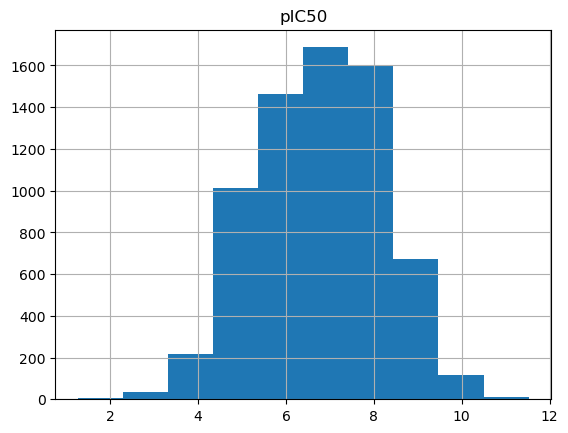

In [95]:
output_df.hist(column="pIC50")

In [96]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

# PandasTools.AddMoleculeColumnToFrame --> If I have a Pandas DataFrame table of molecule SMILES strings, I get that I can use PandasTools. 
# AddMoleculeColumnToFrame() to add a column of structure images that will be displayed when out put to a Jupyter Noth book.
# However, when the table is very laget(e.g., over ~100 rows), only the first 5 nad last 5 rows are shwon.

# PandasTools.AddMoleculeColumnToFrame's parameter --> frame/smilesCol="smiles"/molCol="ROMol"/includeFingerprints="False"
# smilesCol에 포함된 molecules를 RDKit molecules로 convert 하고 지정된 column 이름을 사용하여 DataFrame에 추가

In [97]:
output_df.columns

Index(['molecule_chembl_id', 'IC50', 'units', 'smiles', 'pIC50', 'ROMol'], dtype='object')

In [98]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

/home/dbsejrgus226/miniconda3/envs/606server_virtual_env_1/lib/python3.12/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,
1,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,
2,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,
3,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,
4,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,
...,...,...,...,...,...,...
6811,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,
6812,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,
6813,CHEMBL490510,1.900000e+07,nM,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O[C@@H]2O[C@H](C...,1.721246,
6814,CHEMBL45068,2.500000e+07,nM,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,1.602060,

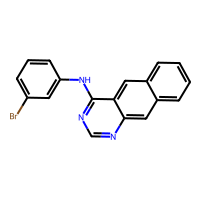
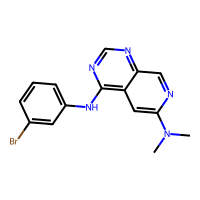
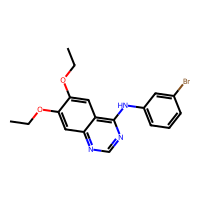
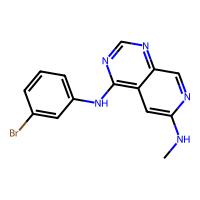
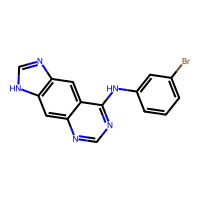
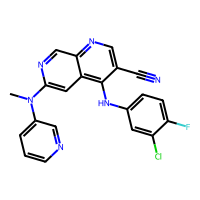
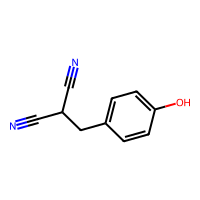
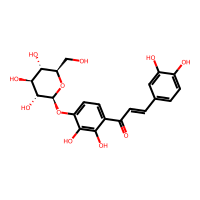
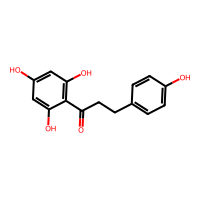
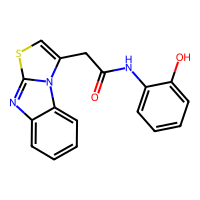

In [99]:
output_df

In [100]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")
output_df.columns

DataFrame shape: (6816, 5)


Index(['molecule_chembl_id', 'IC50', 'units', 'smiles', 'pIC50'], dtype='object')

In [101]:
output_df.to_csv("EGFR_compunds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
